# Coding Exercise 2

## The model

- There is only one agent who governs all resource allocations in the economy. She produces a (single) good through a production function:

    $$
    y_{t} = f(k_{t}) \tag{1}
    $$

- The good can be used for consumption and investment. 

- In this exercise, we introduce a partial capital depreciation, i.e. capital depreciates at the rate $0<\delta<1$ each period. Hence the resource constraint for the agent is:

    <a id='constraint'></a>
    $$
    k_{t+1} + c_t = y_t + (1-\delta)k_t \tag{2}
    $$

- The agent wants to maximize

    <a id='lifetime_utility'></a>
    $$
    \mathbb E \left[ \sum_{t = 0}^{\infty} \beta^t u(c_t) \right] \tag{3}
    $$
    subject to [(2)](#constraint), where $ \beta \in (0, 1) $ is a discount factor. 
   
- The model is almost identical to Cass-Koopmans planning model. In order to solve this model, we will apply value function iteration algorithm. Hence, we first reformulate the maximization problem into a Bellman equation. 

### The Bellman Equation

We can write the value function for the agent's utility maximization problem in the form of **Bellman equation**. In this exercise we will use capital ($k$) as state variable instead of output ($y$). The value function is defined as follows:

<a id='value_fn'></a>
$$
v(k) = \max_{0 \leq c \leq y + (1-\delta)k}
    \left\{ u(c) + \beta v(k') \right\} \tag{4}
$$
subject to 
$$
k' = f(k) + (1-\delta)k - c 
$$

This formulation takes consumption ($c$) as control variable. For the computation below we will use the next period capital ($k'$) as control variable. Then [(4)](#value_fn) can be rewritten as follows:

<a id='Bellman_eq'></a>
$$
v(k) = \max_{0 \leq k' \leq y + (1-\delta)k}
    \left\{ u\left(f(k) + (1-\delta)k - k'\right) + \beta v(k') \right\} \tag{5}
$$

Essentially we converted the constrained maximization problem in [(4)](#value_fn) into the unconstrained maximization problem in [(5)](#Bellman_eq).

## Question 1: Computation with Value Function Iteration

Let's solve for the value function and the optimal policy through the value function iteration method. The algorith is similar to that in the lecture. But the algorithm should be much simpler since no uncertainty is involved in this exercise. No need to compute the Monte Carlo integration here. Due to partial capital depreciation, the value function and the optimal policy function do not allow for analytic form in this exercise.

1. jit-compile codes using `numba` package.
1. `brent_max` will be used to find the optimal policy for each state. 
1. `interpolation.interp` will be used to evaluate the value function at an off-grid point.

### Q.1-0: Import necessary packages.

In [255]:
# your code here
from interpolation import interp
from numba import jit, njit, prange, float64, int32
from numba.experimental import jitclass
from quantecon.optimize.scalar_maximization import brent_max
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (9,6)

### Q.1-1: Define the class for the model economy

Write a class **OptimalGrowth** that specifies the following.

- discount factor: $\beta = 0.96$
- uility function: $\frac{c^{1-\gamma}}{1-\gamma}$ with $\gamma=2$
- production function: $f(k) = k^\alpha$ with $\alpha = 0.4$
- capital depreciation rate: $\delta=0.1$
- grid vector for the state variable: $k \in [0.1, 10]$ with grid_size = 500
- collect the model parameters and declare their types in **opt_growth_data**
- jit-compile the class with `@jitclass`

The contents of the class should be very similar to those from the lecture.

In [256]:
# your code here
opt_growth_data = [
    ('α', float64),          # Production parameter
    ('β', float64),          # Discount factor
    ('γ', float64),           # Preference parameter
    ('δ', float64),           # capital depreciation rate
    ('grid', float64[:]),    # Grid (array)
]

@jitclass(opt_growth_data)
class OptimalGrowth:

    def __init__(self,
                α=0.4, 
                β=0.96,
                γ=2,
                δ=0.1,
                grid_max=10,
                grid_size=500,
                seed=1234):

        self.α, self.β, self.γ, self.δ = α, β, γ, δ

        # Set up grid
        self.grid = np.linspace(0.1, grid_max, grid_size)

       
    def f(self, k):
        "The production function"
        return k**self.α

    def u(self, c):
        "The utility function"
        return c**(1 - self.γ) / (1 - self.γ)
    

    def objective(self, nk, k, v_array):
        """
        Right hand side of the Bellman equation.

         * nk is next period capital
         * k is capital
         * og is an instance of OptimalGrowth
         * v_array represents a guess of the value function on the grid

        """

        u, f,β,δ = self.u, self.f, self.β, self.δ

        v = lambda x: interp(self.grid, v_array, x)

        return u(f(k)+(1-δ)*k-nk) + β * v(nk)    

### Q.1-2: Define the Bellman Operator

Write a function that defines the right-hand side of the Bellman equation.

- function head: **T(v, og_VI)** 
- `v` is the vector of value function in the current iteration.
- `og_VI` is the instance of the class `OptimalGrowth_VI` to be initiated later.
- solve the maximization problem using `brent_max` function. You may refer to [this site](https://quanteconpy.readthedocs.io/en/latest/optimize/scalar_maximization.html) to find the usage of `brent_max`.
- use `brent_max` function with caution in setting the range of $k'$ to make sure consumption nonnegative.
- update the value function `v_new` and the optimal policy function `v_greedy`.
- jit-compile the function with `@njit`

In [257]:
# your code here
@njit
def T(v, og_VI):
    v_new = np.empty_like(v)
    v_greedy = np.empty_like(v)

    for j in range(len(og_VI.grid)):
        k = og_VI.grid[j]

        # Maximize RHS of Bellman equation at state k
        result = brent_max(og_VI.objective, 1e-10, og_VI.f(k)+0.9*k, args=(k, v))
        v_greedy[j], v_new[j] = result[0], result[1]

    return v_greedy, v_new

### Q.1-3: Implement the Value Function Iteration

Write a function that iterates the Bellman operator until the value function converges. 

- function head: `solve_model_VI(og_VI, tol=1e-4, max_iter=1000, print_skip=20)`
- the arguements are analogous to those in the lecture.
- use the grid vector for the state variable itself as the initial guess for the value function.
- while iterating, the function should show the progress every 20 iteration.
- the function should return the converged value function and the accompanying greedy function.

In [258]:
# your code here
def solve_model_VI(og_VI,
                tol=1e-4,
                max_iter=1000,
                print_skip=20,
                verbose = True):
    """
    Solve model by iterating with the Bellman operator.

    """

    # Set up loop
    v = og_VI.u(og_VI.grid)  # Initial condition
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_greedy, v_new = T(v, og_VI)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_greedy, v_new

### Q.1-4: Run the Value function iteration

- create an instance of the class OptimalGrowth_VI `og_VI` with the default parameter values defined in the class.
- run `solve_model_VI`.
- using the converged policy function `k_opt_VI`, compute the optimal consumption with respect to capital `c_opt_VI`. 
- plot figures for the converged value function, the policy function and the consumption function.


In [259]:
# your code here

# create an instance of the class OptimalGrowth_VI og_VI with the default parameter values defined in the class
og_VI = OptimalGrowth(α=0.4, 
                β=0.96,
                γ=2,
                δ=0.1,
                grid_max=10,
                grid_size=500,
                seed=1234)

# run solve_model_VI
k_opt, v_new = solve_model_VI(og_VI,
                tol=1e-4,
                max_iter=1000,
                print_skip=20,
                verbose = True)

Error at iteration 20 is 0.3886781008870521.
Error at iteration 40 is 0.15387619381741047.
Error at iteration 60 is 0.06669488089628572.
Error at iteration 80 is 0.02936971118219489.
Error at iteration 100 is 0.012972191087037288.
Error at iteration 120 is 0.005732919080493559.
Error at iteration 140 is 0.0025338797364433674.
Error at iteration 160 is 0.0011199689402907609.
Error at iteration 180 is 0.000495030382825945.
Error at iteration 200 is 0.0002188032889485214.
Error at iteration 220 is 9.671651267595394e-05.

Converged in 220 iterations.


In [260]:
# using the converged policy function k_opt_VI, compute the optimal consumption with respect to capital c_opt_VI
k_opt_VI = k_opt
c_opt_VI = og_VI.f(k_opt_VI)+(1-og_VI.δ)*k_opt_VI-k_opt_VI
c_opt_VI

array([0.52285978, 0.55057108, 0.57188818, 0.59081848, 0.61188078,
       0.62720598, 0.64197855, 0.6582735 , 0.67360654, 0.68544415,
       0.69697788, 0.70999868, 0.72234154, 0.73403294, 0.74445814,
       0.75341204, 0.76288855, 0.77295283, 0.78264693, 0.79200478,
       0.8010515 , 0.80980939, 0.81806408, 0.82540372, 0.83260067,
       0.83999673, 0.84765187, 0.85510132, 0.86236514, 0.86945669,
       0.87638551, 0.88315927, 0.88978414, 0.89626784, 0.90261792,
       0.90883836, 0.91493405, 0.92091   , 0.92662622, 0.93212975,
       0.93755342, 0.94289893, 0.94817047, 0.95336754, 0.95849308,
       0.96359357, 0.96871972, 0.97376325, 0.97872738, 0.98361121,
       0.98841877, 0.99315418, 0.99782131, 1.00242352, 1.00696202,
       1.01143702, 1.01584988, 1.02020213, 1.02449528, 1.02873064,
       1.03290993, 1.03703177, 1.04109812, 1.04511252, 1.0490782 ,
       1.05299838, 1.05687345, 1.06070233, 1.06448549, 1.06822375,
       1.07191794, 1.07556865, 1.0791773 , 1.08274113, 1.08626

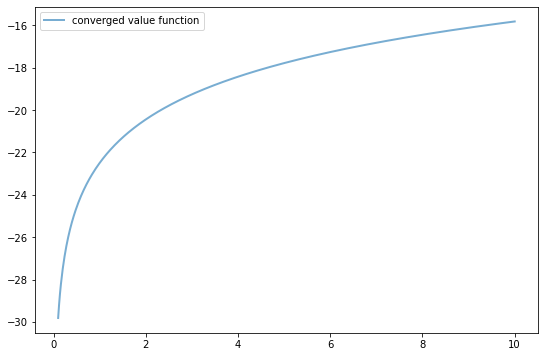

In [261]:
# plot figures for the converged value function
fig, ax = plt.subplots()
ax.plot(og_VI.grid, v_new, lw=2, alpha=0.6, label='converged value function')
ax.legend()
plt.show()

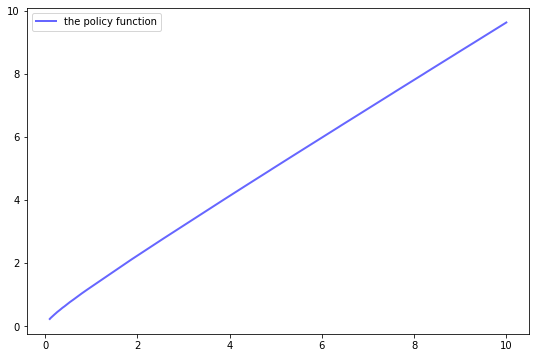

In [262]:
# plot figures for the policy function
fig, ax = plt.subplots()
ax.plot(og_VI.grid, k_opt_VI, 'b-', lw=2, alpha=0.6, label='the policy function')
ax.legend()
plt.show()

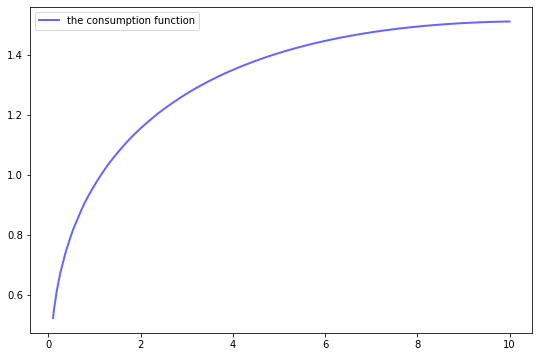

In [263]:
# plot figures for the consumption function.
fig, ax = plt.subplots()
ax.plot(og_VI.grid, c_opt_VI, 'b-', lw=2, alpha=0.6, label='the consumption function')
ax.legend()
plt.show()

### Q.1-5: Compute the time-series of capital and consumption

Suppose that the agent is endowed with $k_0$ at the very first period of her life. Each period, she chooses $k_{t+1}$, equivalently $c_t$, according to the policy function computed above. We want to compute the time-series of $k_t$ and $c_t$ thoughout her life using the optimal policy functions computed above.

Write a function that simulates the capital and consumption of the agent. This function will be used again for the time iteration algorithm below.

- function head: Simulate_Time_Series(T, k0, og, k_opt, c_opt)
    - `T`: length of time-series
    - `k0`: initial capital holdings
    - `og`: model
    - `k_opt`: converged policy function for $k'$ 
    - `c_opt`: policy function for $c$ 
- need to interpolate policy functions
- compute and plot the time-series $\{k_t, c_t\}$ for $t=0, 1, \cdots T$.


In [264]:
# your code here
from scipy.interpolate import interp1d

def Simulate_Time_Series(T, k0, og, k_opt, c_opt):
    k = np.empty(T)
    c = np.empty(T)
    k[0] = k0
    c[0] = og.f(k0)+(1-og.δ)*k0-k0
    k_func = lambda x: interp(og.grid, k_opt, x)
    c_func = lambda x: interp(og.grid, c_opt, x)
    for t in range(T-1):
        k[t+1] = k_func(k[t])
        c[t+1] = c_func(c[t])
    return k,c

### Q.1-6: Generate and plot the time series of capital and consumption

Generate and plot `k_path_VI` and `c_path_VI` for $t=0, 1, \cdots, 100$ with $k_0 = 1$.

In [265]:
# your code here

og = OptimalGrowth(α=0.4, 
                β=0.96,
                γ=2,
                δ=0.1,
                grid_max=10,
                grid_size=500,
                seed=1234)

# Generate k_path_VI and c_path_VI
k_path_VI, c_path_VI = Simulate_Time_Series(T=101, k0=1, og=og, k_opt=k_opt_VI, c_opt=c_opt_VI)

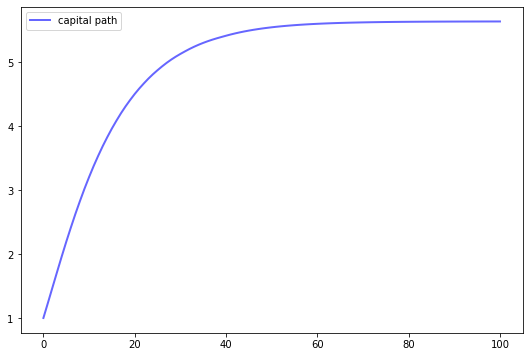

In [266]:
# plot k_path_VI
fig, ax = plt.subplots()
ax.plot(k_path_VI, 'b-', lw=2, alpha=0.6, label='capital path')
ax.legend()
plt.show()

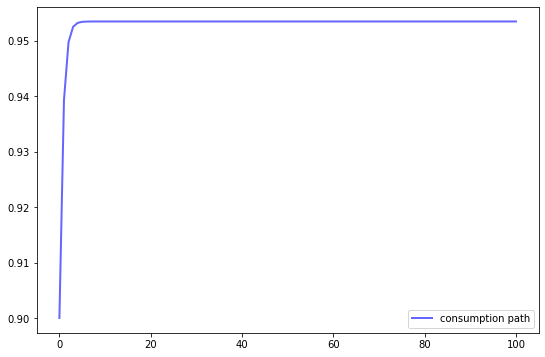

In [267]:
# plot c_path_VI
fig, ax = plt.subplots()
ax.plot(c_path_VI, 'b-', lw=2, alpha=0.6, label='consumption path')
ax.legend()
plt.show()

## Question 2: Computation with Time Iteration

Now we will solve the above model with a different computation algorithm, time iteration by Coleman. The utility and production functions satisfy all assumptions for the value function to be strictly concave, increasing and continuously differentiable. Hence the first-order conditions for the maximization yield the **Euler equation** as follows:

$$
u' (c) = \beta u'(c') [f'(k') + 1 - \delta]
$$

Equivalently, using the resource constraint, it can be written as:

$$
u' \left( f(k) + (1-\delta)k - k' \right) = \beta u' \left( f(k') + (1-\delta)k' - k'' \right) \left[ f'(k') + 1 - \delta \right]
$$

This Euler equation takes the form of the second order deffference equation, which is difficult to solve for. However, the essence of the time iteration algorithm is to find the fixed point of the policy function, $k' = \sigma^*(k)$, through iterating the Coleman operator $K\sigma$ that is defined:

<a id='euler_eq'></a>
$$
u' \left( f(k) + (1-\delta)k - k' \right) = \beta u' \left( f(k') + (1-\delta)k' - \sigma(k') \right) \left[ f'(k') + 1 - \delta \right] \tag{6}
$$


### Q.2-1: Define the new class for the Time Iteration

- class name: **OptimalGrowth_TI**
- use the same parameter values as in the previous class **OptimalGrowth_VI**.
- use the same production and utility functions as in **OptimalGrowth_VI**.
- define functions for the derives of production and utility functions.
- define a function for the Euler equation.
- collect the model parameters and declare their types in **opt_growth_data**.
- jit-compile the class with `@jitclass`


In [268]:
# your code here
from quantecon.optimize import brentq
import quantecon as qe

plt.rcParams['figure.figsize'] = (10,6)

opt_growth_data = [
    ('α', float64),          # Production parameter
    ('β', float64),          # Discount factor
    ('γ', float64),           # Preference parameter
    ('δ', float64),           # capital depreciation rate
    ('grid', float64[:]),    # Grid (array)
]

@jitclass(opt_growth_data)
class OptimalGrowth_TI:

    def __init__(self,
                α=0.4, 
                β=0.96,
                γ=2,
                δ=0.1,
                grid_max=10,
                grid_size=500,
                seed=1234):

        self.α, self.β, self.γ, self.δ = α, β, γ, δ

        # Set up grid
        self.grid = np.linspace(0.1, grid_max, grid_size)

       
    def f(self, k):
        "The production function"
        return k**self.α

    def u(self, c):
        "The utility function"
        return c**(1 - self.γ) / (1 - self.γ)

    def f_prime(self, k):
        "Derivative of f"
        return self.α * (k**(self.α - 1))


    def u_prime(self, c):
        "Derivative of u"
        return c**(-self.γ)


    def euler_diff(self, nk, σ, k):
        """
        Set up a function such that the root with respect to nk,
        given k and σ, is equal to Kσ(k).

        """

        β, δ, grid = self.β, self.δ,self.grid
        f, f_prime, u_prime = self.f, self.f_prime, self.u_prime

        # First turn σ into a function via interpolation
        σ_func = lambda x: interp(grid, σ, x)

        # Now set up the function we need to find the root of.
        # nk is k'
        vals = u_prime(f(nk)+(1-δ)*nk-σ_func(nk))*(f_prime(nk)+1-δ)
        return u_prime(f(k)+(1-δ)*k-nk) - β * vals

### Q.2-2: Define the Coleman operator

Write a function that defines the Coleman operator $K$ that updates the optimal policy function $\sigma$ by solving the (nonlinear) Equler equation for the optimal $k'$. The contents of the function should be very similar to those of `T`, the Bellman operator for the value function iteration algorithm. 

- function head: **K($\sigma$, og_TI)**
- $\sigma$ is the vector of optimal policy for $k'$ in the current iteration.
- `og_TI` is the instance of the class OptimalGrowth_TI to be initiated later.
- solve the nonlinear euqation for $k'$ for each grid of $k$ using `brentq` function. You may refer to [this site](https://quanteconpy.readthedocs.io/en/latest/optimize/root_finding.html) to find the usage of `brentq`.
- update the policy value function $\sigma_{new}$.
- jit-compile the function with @njit
- need to import `brentq`:

In [269]:
from quantecon.optimize.root_finding import brentq

- code for the function **K($\sigma$, og_TI)** below:

In [270]:
# your code here
@njit
def K(σ, og_TI):
    """
    The Coleman-Reffett operator

     Here og is an instance of OptimalGrowthModel.
    """

    β,δ = og_TI.β, og_TI.δ
    f, f_prime, u_prime = og_TI.f, og_TI.f_prime, og_TI.u_prime
    grid = og_TI.grid

    σ_new = np.empty_like(σ)
    for i, k in enumerate(grid):
        # Solve for optimal nk at k
        results = brentq(og_TI.euler_diff, 1e-10, f(k)+(1-δ)*k-1e-10, args=(σ, k))
        σ_new[i] = results[0]

    return σ_new

### Q.2-3: Implement the Time Iteration

Write a function that iterates the Coleman operator until the policy function converges. 

- function head: `solve_model_TI(og_TI, tol=1e-4, max_iter=1000, print_skip=5)`
- the contents of the function are similar to those in the previous `solve_model_VI`.

In [271]:
# your code here
def solve_model_TI(og_TI,    # Class with model information
                   σ,        # Initial condition
                   tol=1e-4,
                   max_iter=1000,
                   print_skip=5,
                   verbose=True):

    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        σ_new = K(σ, og_TI)
        error = np.max(np.abs(σ - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        σ = σ_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return σ_new

### Q.2-4: Run the Time Iteration

- create an instance of the class OptimalGrowth `og_TI` with the default parameter values defined in the class.
- run `solve_model_TI`.
- using the converged policy function `k_opt_TI`, compute the optimal consumption with respect to capital `c_opt_TI`. 
- plot figures for the converged policy function and the consumption function.
- compute the steady state capital $k^*$ such that $k^*=k'(k^*)$ which is the solution to $1 = \beta \left(f'(k^*) + 1- \delta \right)$. 
- add a 45 degree line on the figure for the policy function to identify the steady state capital.
- put a mark at the coordinate of the steady state in the figure for the policy function.

In [272]:
# your code here

# create an instance of the class OptimalGrowth og_TI
og_TI = OptimalGrowth_TI(α=0.4, 
                β=0.96,
                γ=2,
                δ=0.1,
                grid_max=10,
                grid_size=500,
                seed=1234)

# run solve_model_TI
σ_init = np.copy(og_TI.grid)
σ = solve_model_TI(og_TI, σ_init)

Error at iteration 5 is 0.029038969280886562.
Error at iteration 10 is 0.0195602206299359.
Error at iteration 15 is 0.009274881700076065.
Error at iteration 20 is 0.003608511692590355.
Error at iteration 25 is 0.001305904237108635.
Error at iteration 30 is 0.00046365244006452144.
Error at iteration 35 is 0.00016423748952121286.

Converged in 38 iterations.


In [273]:
# using the converged policy function k_opt_TI, compute the optimal consumption with respect to capital c_opt_TI
k_opt_TI = σ
c_opt_TI = og_TI.f(k_opt_TI)+(1-og_TI.δ)*k_opt_TI-k_opt_TI
c_opt_TI

array([0.52463952, 0.54957384, 0.57178744, 0.5918603 , 0.61027032,
       0.62731484, 0.64319734, 0.65810673, 0.67217531, 0.68550859,
       0.69818425, 0.71028205, 0.7218605 , 0.73296914, 0.74364961,
       0.75393741, 0.76386443, 0.77346063, 0.78275034, 0.79175509,
       0.80049407, 0.80898452, 0.81724193, 0.82528026, 0.8331112 ,
       0.84074717, 0.84819887, 0.85547587, 0.86258699, 0.86954032,
       0.87634327, 0.88300279, 0.88952535, 0.89591691, 0.90218302,
       0.90832885, 0.91435924, 0.92027871, 0.9260915 , 0.93180158,
       0.93741271, 0.94292839, 0.94835184, 0.95368636, 0.95893491,
       0.96410031, 0.96918522, 0.97419216, 0.97912354, 0.98398163,
       0.9887686 , 0.99348651, 0.99813733, 1.00272295, 1.00724517,
       1.0117057 , 1.01610616, 1.02044814, 1.02473314, 1.02896261,
       1.03313794, 1.03726044, 1.04133139, 1.045352  , 1.04932346,
       1.05324691, 1.05712345, 1.06095412, 1.06473992, 1.06848183,
       1.07218081, 1.07583777, 1.07945359, 1.08302911, 1.08656

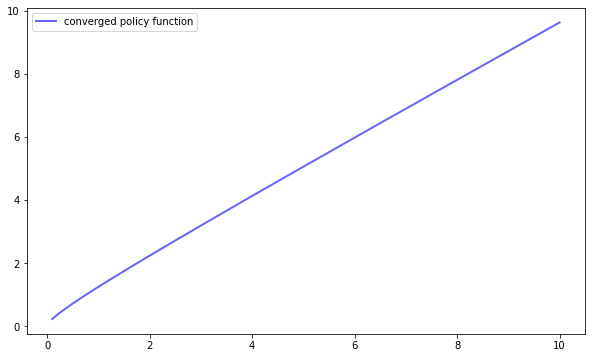

In [274]:
# plot figures for the converged policy function
fig, ax = plt.subplots()
ax.plot(og_TI.grid, k_opt_TI, 'b-', lw=2, alpha=0.6, label='converged policy function')
ax.legend()
plt.show()

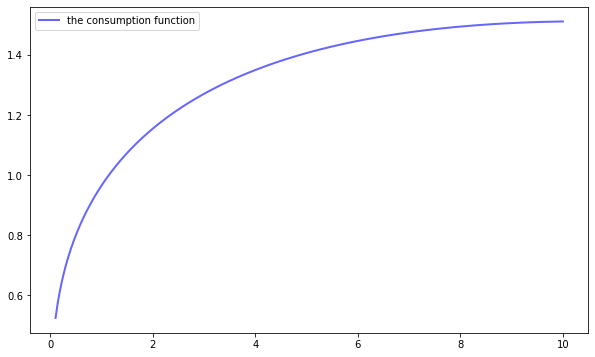

In [275]:
# plot figures for the consumption function
fig, ax = plt.subplots()
ax.plot(og_TI.grid, c_opt_TI, 'b-', lw=2, alpha=0.6, label='the consumption function')
ax.legend()
plt.show()

In [276]:
# compute the steady state capital 𝑘∗
def f_prime_inv(k):
    return (k/og_TI.α)**(1/(og_TI.α-1))

k_ss = f_prime_inv(1/og_TI.β-1+og_TI.δ)
k_ss

5.640537964584442

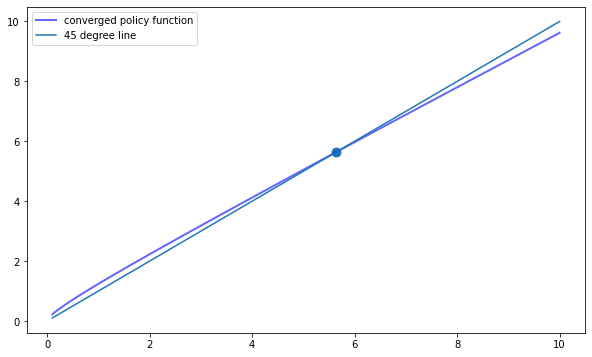

In [277]:
# add a 45 degree line on the figure for the policy function to identify the steady state capital
fig, ax = plt.subplots()
ax.plot(og_TI.grid, k_opt_TI, 'b-', lw=2, alpha=0.6, label='converged policy function')
ax.plot(og_TI.grid, og_TI.grid, label = '45 degree line')
# put a mark at the coordinate of the steady state in the figure for the policy function
ax.scatter(k_ss, k_ss, s=80)
ax.legend()
plt.show()

### Q.2-5: Generate and plot the time-series of capital and consumption

- Generate and plot `k_path_TI` and `c_path_TI` for $t=0, 1, \cdots, 100$ with $k_0 = 1$.
- You should get the identical figures for `k_path_TI` and `c_path_TI` as `k_path_VI` and `c_path_VI` in Q.1-6.
- You don't need to write a fucntion to generate the time-series, but you can just use `Simulate_Time_Series` function that you defined for Q.1-5.

In [278]:
# your code here

# Generate k_path_TI and c_path_TI
og_TI = OptimalGrowth_TI(α=0.4, 
                β=0.96,
                γ=2,
                δ=0.1,
                grid_max=10,
                grid_size=500,
                seed=1234)

k_path_TI, c_path_TI = Simulate_Time_Series(T=101,k0=1,og=og_TI, k_opt=k_opt_TI, c_opt=c_opt_TI )

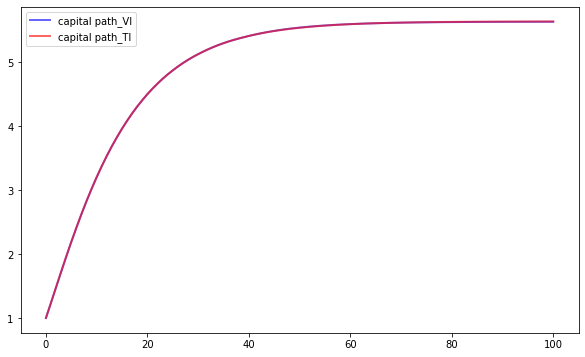

In [279]:
# plot k_path_TI
fig, ax = plt.subplots()
ax.plot(k_path_VI, 'b-', lw=2, alpha=0.6, label='capital path_VI')
ax.plot(k_path_TI, 'r-', lw=2, alpha=0.6, label='capital path_TI')
ax.legend()
plt.show()

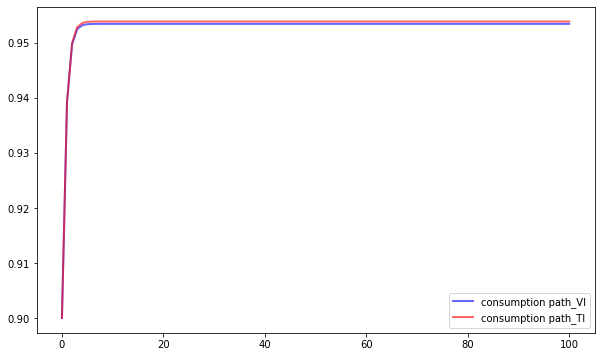

In [280]:
# plot c_path_TI
fig, ax = plt.subplots()
ax.plot(c_path_VI, 'b-', lw=2, alpha=0.6, label='consumption path_VI')
ax.plot(c_path_TI, 'r-', lw=2, alpha=0.6, label='consumption path_TI')
ax.legend()
plt.show()

## Qeustion 3: Computation with Endogenous Grid Method

Now we will solve the above model with a different computation algorithm, endogenous grid method by Carroll. The Euler equation in [(6)](#euler_eq) can be manipulated as: 

<a id='euler_egm'></a>
$$
f(k) + (1-\delta)k - k' = u'^{-1} \left( \beta u' \left( f(k') + (1-\delta)k' - k'' \right) \left[ f'(k') + 1 - \delta \right] \right)
$$

Although it is possible to keep capital as a state variable, it is more tractable to use the total resource $y = f(k) + (1-\delta)k$ as a state variable, which is disposed of $y = k' + c$. The policy function can be defined $\sigma: y \to k'$. According to this formulation, the Euler equation yields: 

$$
y - k' = u'^{-1} \left( \beta u' \left( y' - \sigma(y') \right) \left[ f'(k') + 1 - \delta \right] \right)
$$

In order to apply the EGM, we construct the fixed grid for $k'$ and the corresponding vector of $y$'s will be determined endogenously such that $y_i = \sigma^{-1}(k'_i)$ for $i=0, 1, \cdots, N-1$.

### Q.3-1: Define the new class for the EGM

- class name: **OptimalGrowth_EGM**
- the class inherits alla the parameters and functions from **OptimalGrowth_TI**.
- it need an additonal function that defines the inverse of the marginal utility: `u_prime_inv` 
- collect the model parameters and declare their types in **opt_growth_data_EHM**.
- jit-compile the class with `@jitclass`


In [281]:
# your code here
opt_growth_data_EGM = [
    ('α', float64),          # Production parameter
    ('β', float64),          # Discount factor
    ('γ', float64),           # Preference parameter
    ('δ', float64),           # capital depreciation rate
    ('grid', float64[:]),    # Grid (array)
]

@jitclass(opt_growth_data_EGM)
class OptimalGrowth_EGM:

    def __init__(self,
                α=0.4, 
                β=0.96,
                γ=2,
                δ=0.1,
                grid_max=10,
                grid_size=500,
                seed=1234):

        self.α, self.β, self.γ, self.δ = α, β, γ, δ

        # Set up grid
        self.grid = np.linspace(0.1, grid_max, grid_size)

       
    def f(self, k):
        "The production function"
        return k**self.α

    def u(self, c):
        "The utility function"
        return c**(1 - self.γ) / (1 - self.γ)

    def f_prime(self, k):
        "Derivative of f"
        return self.α * (k**(self.α - 1))


    def u_prime(self, c):
        "Derivative of u"
        return c**(-self.γ)

    def u_prime_inv(self, c):
        "Inverse of u'"
        return c**(-1/self.γ)

### Q.3-2: Define the modified Coleman operator

The modified Coleman operator $G$ is defined to reflect the endogenous grid method. 

- function head: **G($\sigma_{inv}$, og_EGM)**
- $\sigma_{inv}$ contains the values of total resources $y_i$'s corresponding to the fixed grid $k'_i$'s in the current iteration.
- `og_EGM` is the instance of the class OptimalGrowth_EGM to be initiated later.
- update the endogenous grid vector $\sigma_{inv-new}$.
- jit-compile the function with @njit


In [282]:
# your code here
@njit
def G(σ_inv, og_EGM):
    """
    The Coleman operator using EGM
    σ_inv(k') = y
    """

    # Simplify names
    f, β,δ = og_EGM.f, og_EGM.β, og_EGM.δ
    f_prime, u_prime = og_EGM.f_prime, og_EGM.u_prime
    u_prime_inv = og_EGM.u_prime_inv
    grid = og_EGM.grid
    
    y = f(grid) + (1-δ)*grid
    σ_inv_func = lambda x: interp(y, σ_inv, x)
    σ_inv_new= np.empty_like(grid)

    # Solve for updated consumption value
    for i, k in enumerate(grid):
        vals = u_prime(σ_inv_func(k)-k) * (f_prime(k)+1-δ)
        σ_inv_new[i] = u_prime_inv(β * vals) + k

    return σ_inv_new

### Q.3-3: Implement the EGM

Write a function that iterates the Coleman operator until the policy function converges. 

- function head: `solve_model_EGM(og_EGM, tol=1e-4, max_iter=1000, print_skip=5)`
- the contents of the function are similar to those in the previous `solve_model_EGM` for the value function iteration algorithm.

In [283]:
# your code here
def solve_model_EGM(og_EGM,    # Class with model information
                          σ_inv,        # Initial condition
                          tol=1e-4,
                          max_iter=1000,
                          print_skip=5,
                          verbose=True):

    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        σ_inv_new = G(σ_inv, og_EGM)
        error = np.max(np.abs(σ_inv - σ_inv_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        σ_inv = σ_inv_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return σ_inv_new

### Q.3-4: Run the EGM

- create an instance of the class OptimalGrowth `og_EGM` with the default parameter values defined in the class.
- run `solve_model_EGM` to get the converged inverse policy function in the vector of which elements are $y_i=\sigma^{-1}(k'_i)$.
- in order to present the results compatible with the previous algorithms, we will convert the state variable back to capital so that the policy function is defined as $\tilde{\sigma}: k \to k'$. In other words, we solve for the endogenous grid vector $k_i$'s such that $y_i = f(k_i) + (1-\delta)k_i$. This is a nonlinear equation to be solved through a nonlinear equation solver sucj as `brentq`. Here, for some reason, `brentq` from `quantecon` raise a stupid error. You'd better use `scipy.optimize.brentq` instead of `quantecon.optimize.root_finding.brentq`.
- using $\tilde{\sigma}$, compute the optimal consumption with respect to capital `c_opt_EGM`. 
- plot figures for the converged policy function and the consumption function.
- compute the steady state capital $k^*$ such that $k^*=k'(k^*)$ which is the solution to $1 = \beta \left(f'(k^*) + 1- \delta \right)$. 
- add a 45 degree line on the figure for the policy function to identify the steady state capital.
- put a mark at the coordinate of the steady state in the figure for the policy function.

In [284]:
# your code here

# create an instance of the class OptimalGrowth og_EGM with the default parameter values defined in the class
og_EGM = OptimalGrowth_EGM(α=0.4, 
                β=0.96,
                γ=2,
                δ=0.1,
                grid_max=10,
                grid_size=500,
                seed=1234)
σ_inv_init = np.copy(og_EGM.grid)
σ_inv = solve_model_EGM(og_EGM, σ_inv_init)

Error at iteration 5 is 1.2884470455358255.
Error at iteration 10 is 0.0.

Converged in 10 iterations.


In [285]:
from scipy.optimize import brentq

# convert the state variable back to capital
σ_tilda = np.empty_like(σ_inv)
σ_inv_tilda = σ_inv
for i in range(σ_inv.size):
    σ_tilda[i] = brentq(lambda x : σ_inv[i] - og_EGM.f(x) - (1-og_EGM.δ) * x, 0, 500)

# compute the optimal consumption with respect to capital c_opt_EGM
k_opt_EGM = σ_tilda
c_opt_EGM = og_EGM.f(k_opt_EGM)+(1-og_EGM.δ)*k_opt_EGM-k_opt_EGM
c_opt_EGM

array([0.09704388, 0.12726473, 0.15703603, 0.18614696, 0.21447485,
       0.24195464, 0.26855923, 0.29428648, 0.31915035, 0.34317495,
       0.36639044, 0.38883026, 0.41052929, 0.43152261, 0.45184469,
       0.47152888, 0.49060714, 0.50910984, 0.52706569, 0.54450178,
       0.55923436, 0.57080901, 0.58212088, 0.5927872 , 0.60323762,
       0.61320653, 0.62290274, 0.63222738, 0.641266  , 0.64999471,
       0.65845458, 0.66663654, 0.67458296, 0.68226488, 0.68975263,
       0.69697756, 0.70405304, 0.71086004, 0.71753513, 0.72398718,
       0.73028892, 0.73642475, 0.74238424, 0.7482258 , 0.75387571,
       0.75941204, 0.76481172, 0.77006672, 0.77522012, 0.78023033,
       0.78513174, 0.7899391 , 0.79460691, 0.79918801, 0.80367629,
       0.80881161, 0.81436081, 0.82044683, 0.82643234, 0.8323963 ,
       0.83836321, 0.84423211, 0.85007004, 0.8558831 , 0.86163684,
       0.86735644, 0.87303727, 0.8786762 , 0.88428272, 0.88984753,
       0.89537119, 0.9008707 , 0.90632683, 0.91174195, 0.91713

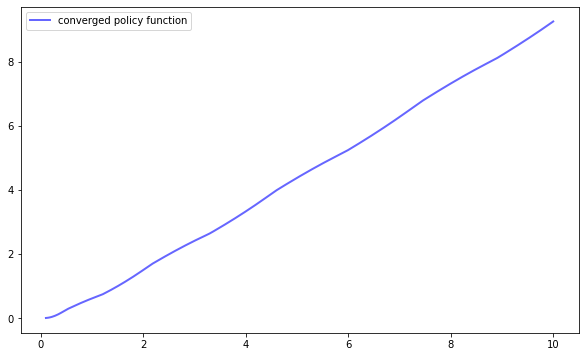

In [286]:
# plot figures for the converged policy function
fig, ax = plt.subplots()
ax.plot(og_EGM.grid, k_opt_EGM, 'b-', lw=2, alpha=0.6, label='converged policy function')
ax.legend()
plt.show()

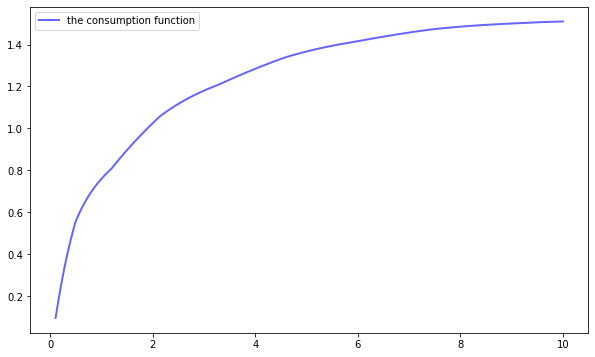

In [287]:
# plot figures for the consumption function
fig, ax = plt.subplots()
ax.plot(og_EGM.grid, c_opt_EGM, 'b-', lw=2, alpha=0.6, label='the consumption function')
ax.legend()
plt.show()

In [288]:
# compute the steady state capital 𝑘∗
def f_prime_inv(k):
    return (k/og_EGM.α)**(1/(og_EGM.α-1))

k_ss_EGM = f_prime_inv(1/og_EGM.β-1+og_EGM.δ)
k_ss_EGM

5.640537964584442

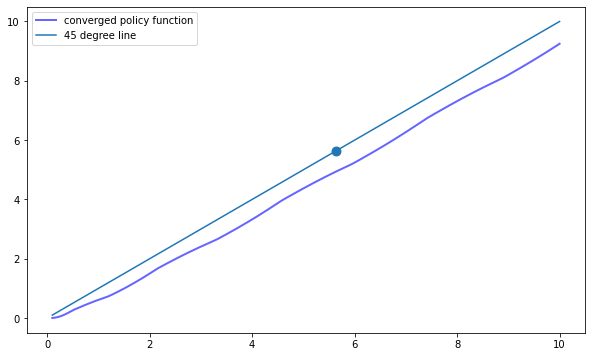

In [289]:
# add a 45 degree line on the figure for the policy function to identify the steady state capital
fig, ax = plt.subplots()
ax.plot(og_EGM.grid, k_opt_EGM, 'b-', lw=2, alpha=0.6, label='converged policy function')
ax.plot(og_EGM.grid, og_EGM.grid, label = '45 degree line')
# put a mark at the coordinate of the steady state in the figure for the policy function
ax.scatter(k_ss_EGM, k_ss_EGM, s=80)
ax.legend()
plt.show()